In [3]:
import tiktoken
import pandas as pd
from nltk.tokenize import word_tokenize, sent_tokenize
import numpy
import matplotlib.pyplot as plt
from datasets import load_dataset

## Dataset loading

In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
dataset = load_dataset("yaful/DeepfakeTextDetect")
df = dataset["train"].to_pandas()
df.head()

Generating train split:   0%|          | 0/319071 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/56792 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/56819 [00:00<?, ? examples/s]

Generating test_ood_gpt split:   0%|          | 0/1562 [00:00<?, ? examples/s]

Generating test_ood_gpt_para split:   0%|          | 0/2362 [00:00<?, ? examples/s]

,text,label,src
0,White girls very rarely date Asian men. Even i...,1,cmv_human
1,I am a 23 year old male Indian American male. ...,1,cmv_human
2,"Take three people, Persons A, B, and C. They l...",1,cmv_human
3,(A) Work part-time in high school; Then go to ...,1,cmv_human
4,When police introduce a new form of speed prev...,1,cmv_human


## Fonction de création de tokens

In [7]:
def lemma_tokenize(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(t) for t in word_tokenize(doc)]

def byte_pair_tokenize(doc):
    enc = tiktoken.encoding_for_model("gpt-4")
    tokens = enc.encode(doc)
    return [str(token) for token in tokens]

def preprocess(text):
    tokens = word_tokenize(text)
    return " ".join(tokens)

## Training Word2Vec

In [8]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from nltk import word_tokenize, sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
df['tokenized_text'] = df['text'].apply(lambda x: word_tokenize(x.lower()))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['tokenized_text'], df.label, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
print(f"Features dimension: {X_train.shape}")

Features dimension: (255256,)


In [11]:
model = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")
word_vectors = model.wv
word_vectors.save("word2vec.wordvectors") # Store the words and their trained embeddings
del model

In [12]:
model = Word2Vec.load("word2vec.model")
model.train(X_train, total_examples=len(X_train), epochs=1)

(46858434, 62040772)

In [13]:
import numpy as np
def text_to_vector(text, model):
    words = [word for word in text if word in model.wv]
    if len(words) == 0:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[word] for word in words], axis=0)

X_train_vectors = np.array([text_to_vector(text, model) for text in X_train])
X_test_vectors = np.array([text_to_vector(text, model) for text in X_test])
print(f"Feature dimension: {X_train.shape}")

Feature dimension: (255256,)


## Training a classifier

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix

classifier = LogisticRegression(random_state=42, class_weight='balanced', penalty = 'l2', max_iter = 1000)
# Create CountVectorizer to convert text into numerical features
vectorizer = CountVectorizer(ngram_range = (3,3), analyzer=lambda x: x)
vectorizer_ngram = CountVectorizer(analyzer=lambda x: x)

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


Model: 1-gram


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.90     45073
           1       0.74      0.79      0.76     18742

    accuracy                           0.86     63815
   macro avg       0.82      0.84      0.83     63815
weighted avg       0.86      0.86      0.86     63815

Model: 2-gram


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.90     45073
           1       0.74      0.79      0.76     18742

    accuracy                           0.86     63815
   macro avg       0.82      0.84      0.83     63815
weighted avg       0.86      0.86      0.86     63815

Model: 3-gram


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.90     45073
           1       0.74      0.79      0.76     18742

    accuracy                           0.86     63815
   macro avg       0.82      0.84      0.83     63815
weighted avg       0.86      0.86      0.86     63815

Model: 4-gram


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.90     45073
           1       0.74      0.79      0.76     18742

    accuracy                           0.86     63815
   macro avg       0.82      0.84      0.83     63815
weighted avg       0.86      0.86      0.86     63815

Model: 5-gram


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.90     45073
           1       0.74      0.79      0.76     18742

    accuracy                           0.86     63815
   macro avg       0.82      0.84      0.83     63815
weighted avg       0.86      0.86      0.86     63815



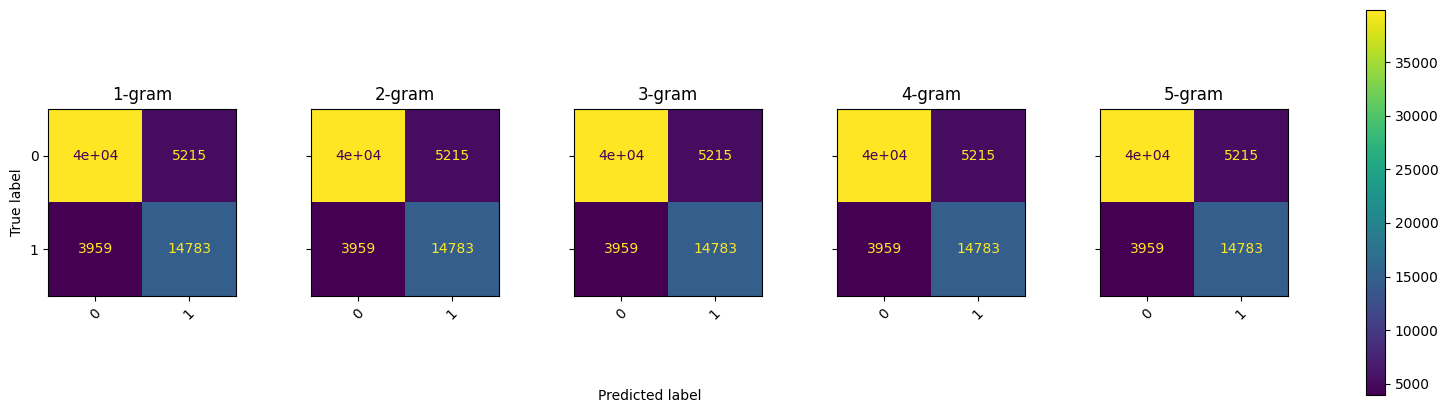

In [18]:
f, axes = plt.subplots(1, 5, figsize=(20, 5), sharey='row')
classifier = LogisticRegression(random_state=42, class_weight='balanced', penalty = 'l2', max_iter = 1000)

for i in range(5):
    print(f"Model: {i+1}-gram")
    vectorizer = CountVectorizer(ngram_range = (i+1,i+1), analyzer=lambda x: x)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    classifier.fit(X_train_vectorized, y_train)
    y_pred = classifier.predict(X_test_vectorized)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=classifier.classes_)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(f"{i+1}-gram")
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0: 
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

f.colorbar(disp.im_, ax=axes)
plt.show()
    